<a href="https://colab.research.google.com/github/baeseungyou/study/blob/main/%ED%85%8D%EC%A0%95_6%EC%A3%BC%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.8/493.8 kB 38.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
train_data = pd.read_csv('nsmc_train.csv')
test_data = pd.read_csv('nsmc_test.csv')

In [5]:
print('훈련 샘플의 개수 :', len(train_data))
print('테스트 샘플의 개수:', len(test_data))

훈련 샘플의 개수 : 150000
테스트 샘플의 개수: 50000


In [6]:
train_data[:5]

,Unnamed: 0,id,document,label
0,0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,2,10265843,너무재밓었다그래서보는것을추천한다,0
3,3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [7]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [8]:
train_data.drop_duplicates(subset=['document'], inplace = True)

In [9]:
print('총 샘플의 수 :', len(train_data))

총 샘플의 수 : 146183


In [10]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [11]:
print(train_data.isnull().values.any())

True


In [12]:
print(train_data.isnull().sum())

Unnamed: 0    0
id            0
document      1
label         0
dtype: int64


In [13]:
train_data.loc[train_data.document.isnull()]

,Unnamed: 0,id,document,label
25857,25857,2172111,NaN,1


In [14]:
train_data = train_data.dropna(how = 'any')
print(train_data.isnull().values.any())

False


In [15]:
print(len(train_data))

146182


In [16]:
train_data['document'] = train_data['document'].str.replace("[^r-ㅎㅏ-ㅣ가-힣]","", regex = True)
train_data[:5]

,Unnamed: 0,id,document,label
0,0,9976970,아더빙진짜짜증나네요목소리,0
1,1,3819312,흠포스터보고초딩영화줄오버연기조차가볍지않구나,1
2,2,10265843,너무재밓었다그래서보는것을추천한다,0
3,3,9045019,교도소이야기구먼솔직히재미는없다평점조정,0
4,4,6483659,사이몬페그의익살스런연기가돋보였던영화스파이더맨에서늙어보이기만했던커스틴던스트가너무나도이...,1


In [17]:
train_data['document'] = train_data['document'].str.replace('^ +', "", regex = True)
train_data.replace({'document':{'': np.nan}}, inplace=True)
print(train_data.isnull().sum())

Unnamed: 0      0
id              0
document      284
label           0
dtype: int64


In [18]:
train_data.loc[train_data.document.isnull()][:5]

,Unnamed: 0,id,document,label
584,584,7117896,NaN,0
593,593,6478189,NaN,0
638,638,9364602,NaN,0
1549,1549,7246718,NaN,1
2073,2073,384233,NaN,1


In [19]:
train_data = train_data.dropna(how = 'any')

In [20]:
print(len(train_data))

145898


In [21]:
test_data.drop_duplicates(subset = ['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace("[^r-ㅎㅏ-ㅣ가-힣]", "")
test_data['document'] = test_data['document'].str.replace('^ + ', "")
test_data.replace({'document': {'', np.nan}}, inplace = True)
test_data = test_data.dropna(how='any')
print('전처리 후 테스트용 샘플의 개수:', len(test_data))

전처리 후 테스트용 샘플의 개수: 49157


In [22]:
print('전처리 후 테스트용 샘플의 개수 :', len(test_data))

전처리 후 테스트용 샘플의 개수 : 49157


In [23]:
stopwords = ['의', '가', '이', '은' ,'들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한' , '하다']

In [24]:
okt = Okt()

In [25]:
X_train = []
for sentence in tqdm(train_data['document']):
  tokenized_sentence = okt.morphs(sentence, stem=True)
  stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
  X_train.append(stopwords_removed_sentence)

100%|██████████| 145898/145898 [1:20:43<00:00, 30.12it/s]


In [26]:
X_test = []
for sentence in tqdm(test_data['document']):
  tokenized_sentence = okt.morphs(sentence, stem = True)
  stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
  X_test.append(stopwords_removed_sentence)

100%|██████████| 49157/49157 [03:32<00:00, 231.41it/s]


In [27]:
print('전처리 후 테스트용 샘플의 개수 : ' , len(X_test))

전처리 후 테스트용 샘플의 개수 :  49157


In [28]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [29]:
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '좋다': 6, '다': 7, '너무': 8, '하': 9, '정말': 10, '재밌다': 11, '적': 12, '되다': 13, '같다': 14, '있다': 15, '만': 16, '진짜': 17, '않다': 18, '~': 19, '로': 20, '아니다': 21, '에서': 22, '내': 23, '평점': 24, '그': 25, '최고': 26, '인': 27, '나': 28, '연기': 29, '생각': 30, '스토리': 31, '점': 32, '게': 33, '이영화': 34, '드라마': 35, '감동': 36, '사람': 37, '만들다': 38, '고': 39, '요': 40, '나오다': 41, '아깝다': 42, '이런': 43, '지': 44, 'ㅋㅋ': 45, '배우': 46, '재미있다': 47, '보고': 48, '왜': 49, '감독': 50, '때': 51, '네': 52, '들다': 53, '하고': 54, '그냥': 55, '아': 56, '재미없다': 57, '시간': 58, '까지': 59, '못': 60, '중': 61, '가다': 62, '지루하다': 63, '것': 64, '뭐': 65, '재미': 66, '쓰레기': 67, '말': 68, '면': 69, '주다': 70, '본': 71, '모르다': 72, '작품': 73, '더': 74, '알다': 75, '오다': 76, '거': 77, '자다': 78, '그렇다': 79, '사랑': 80, '마지막': 81, '저': 82, '대': 83, '정도': 84, '화': 85, 'ㅠㅠ': 86, '이나': 87, '많다': 88, '완전': 89, 'ㅋㅋㅋ': 90, '처음': 91, '라': 92, 'ㅋ': 93, '안되다': 94, '개': 95, '액션': 96, '이렇게': 97, '주인공': 98, '최악': 99, '니': 100, '내용': 101, '느낌': 102,

In [30]:
print(tokenizer.word_counts.items())

odict_items([('아더', 9), ('빙', 7), ('진짜', 7993), ('짜증나다', 1016), ('목소리', 370), ('흠', 216), ('포스터', 548), ('보고', 4181), ('초딩', 411), ('영화', 44397), ('줄', 627), ('오버', 139), ('연기', 5323), ('조차', 212), ('가볍다', 360), ('않다', 7705), ('너', 1249), ('무재', 118), ('밓었', 1), ('다그', 440), ('래서', 38), ('보다', 37718), ('추천', 1141), ('다', 11005), ('교도소', 16), ('이야기', 2065), ('구먼', 10), ('솔직하다', 1196), ('재미', 3445), ('없다', 15210), ('평점', 6181), ('조정', 36), ('사이', 200), ('몬페', 3), ('그', 5842), ('익살스럽다', 9), ('돋보이다', 288), ('스파이더맨', 63), ('에서', 6468), ('늙다', 199), ('보이다', 903), ('크다', 1164), ('스틴던스트', 5), ('너무나도', 205), ('이쁘다', 1047), ('막', 239), ('걸음', 17), ('마', 205), ('떼다', 152), ('초등학교', 116), ('학년', 122), ('생인', 6), ('살다', 1038), ('ㅋㅋㅋ', 2450), ('별', 1814), ('반개', 194), ('아깝다', 4338), ('움', 1033), ('원작', 1174), ('긴장감', 827), ('을제', 73), ('대로', 614), ('살리다', 501), ('다욕', 35), ('나오다', 4451), ('이응경', 7), ('길용우', 4), ('생활', 120), ('몇년', 23), ('인지', 1132), ('정말', 9374), ('발', 233), ('로', 7556), ('해도', 465)

In [33]:
threshold = 3
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
  total_freq = total_freq + value

  if(value < threshold):
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 : ', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 :  47327
등장 빈도가 2번 이하인 희귀 단어의 수: 26187
단어 집합에서 희귀 단어의 비율: 55.33205147167579
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.0058876349716064


In [34]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 : ', vocab_size)

단어 집합의 크기 :  21141


In [35]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = tokenizer.texts_to_sequences(X_test)

In [36]:
print(X_train[:3])

[[729, 93], [], [65, 151, 24, 438, 18, 32, 244, 997, 74, 834, 21]]


In [37]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [38]:
print(len(X_train))
print(len(y_train))

49157
145898


In [39]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1 ]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1 ]

In [40]:
print(drop_train)

[1, 116, 174, 254, 468, 504, 558, 712, 743, 877, 880, 884, 937, 998, 1156, 1183, 1209, 1297, 1305, 1355, 1570, 1718, 1908, 2260, 2304, 2359, 2398, 2412, 2559, 2662, 2686, 3054, 3076, 3248, 3302, 3523, 3753, 3788, 3959, 3988, 4075, 4233, 4515, 4527, 4804, 4966, 5113, 5216, 5239, 5862, 5954, 5973, 6144, 6147, 6154, 6164, 6246, 6323, 6595, 6688, 6756, 6917, 6992, 7015, 7173, 7212, 7702, 7830, 7885, 7978, 8080, 8354, 8398, 8465, 8483, 8599, 8627, 8814, 9007, 9041, 9400, 9456, 9515, 9539, 9775, 9859, 10103, 10243, 10585, 10634, 10675, 10921, 11001, 11069, 11505, 11576, 11712, 11979, 12072, 12501, 12516, 12702, 12716, 12855, 12934, 12964, 13131, 13246, 13326, 13486, 13518, 13604, 13691, 13779, 13873, 13987, 14175, 14424, 14546, 14553, 14720, 15256, 15271, 15295, 15454, 15489, 15879, 15910, 15966, 16001, 16101, 16371, 16449, 16616, 16690, 16854, 16983, 16993, 17032, 17081, 17083, 17342, 17471, 17596, 17680, 17692, 17732, 17832, 17835, 18110, 18950, 19018, 19393, 19395, 19407, 19514, 19518, 19

In [41]:
len(drop_train)

370

In [42]:
X_train = [row for i, row in enumerate(X_train) if i not in drop_train]
y_train = [label for i, label in enumerate(y_train) if i not in drop_train]

In [43]:
X_train = [row for i, row in enumerate(X_test) if i not in drop_train]
y_train = [label for i, label in enumerate(y_test) if i not in drop_train]

리뷰의 최대 길이 : 78
리뷰의 평균 길이 :  12.631582183778466


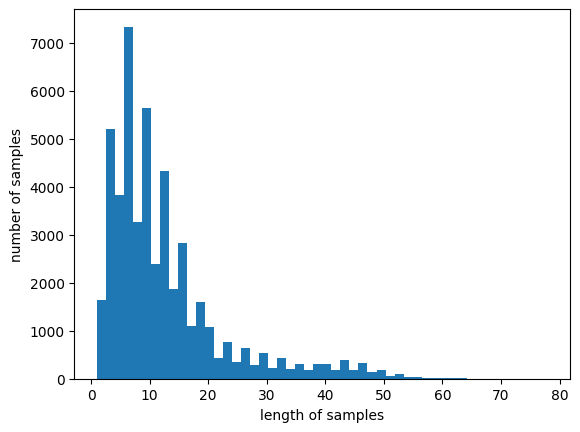

In [44]:
print('리뷰의 최대 길이 :', max(len(l) for l in X_train))
print('리뷰의 평균 길이 : ', sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [45]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
      cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s' %(max_len, (cnt / len(nested_list)) * 100))

In [46]:
max_len = 30
below_threshold_len(max_len, X_train)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
전체 샘플 중 길이가 30 이하인 샘플의 비율: 83.00161928382562
전체 샘플 중 길이가 30 이하인 샘플의 비율: 83.00366901018714
전체 샘플 중 길이가 30 이하인 샘플의 비율: 83.00571873654867
전체 샘플 중 길이가 30 이하인 샘플의 비율: 83.0077684629102
전체 샘플 중 길이가 30 이하인 샘플의 비율: 83.00981818927173
전체 샘플 중 길이가 30 이하인 샘플의 비율: 83.01186791563326
전체 샘플 중 길이가 30 이하인 샘플의 비율: 83.0139176419948
전체 샘플 중 길이가 30 이하인 샘플의 비율: 83.01596736835633
전체 샘플 중 길이가 30 이하인 샘플의 비율: 83.01801709471786
전체 샘플 중 길이가 30 이하인 샘플의 비율: 83.02006682107938
전체 샘플 중 길이가 30 이하인 샘플의 비율: 83.02211654744092
전체 샘플 중 길이가 30 이하인 샘플의 비율: 83.02416627380245
전체 샘플 중 길이가 30 이하인 샘플의 비율: 83.02621600016397
전체 샘플 중 길이가 30 이하인 샘플의 비율: 83.0282657265255
전체 샘플 중 길이가 30 이하인 샘플의 비율: 83.03031545288704
전체 샘플 중 길이가 30 이하인 샘플의 비율: 83.03236517924857
전체 샘플 중 길이가 30 이하인 샘플의 비율: 83.0344149056101
전체 샘플 중 길이가 30 이하인 샘플의 비율: 83.03646463197163
전체 샘플 중 길이가 30 이하인 샘플의 비율: 83.03851435833316
전체 샘플 중 길이가 30 이하인 샘플의 비율: 83.0405640846947
전체 샘플 중 길이가 30 이하인 샘플의 비율: 83.04261381105621
전체 샘플 중 길이가 30 이하인 샘플의 비

In [49]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [50]:
y_train = np.expand_dims(y_train, axis = -1)

In [51]:
y_test = np.expand_dims(y_test, axis = -1)

In [52]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [53]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 4)
mc = ModelCheckpoint('best_model.keras', monitor = 'val_acc', mode='max', verbose=1, save_best_only = True)

In [54]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation = 'sigmoid'))

In [56]:
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split= 0.2)

Epoch 1/15
608/610 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.6908 - loss: 0.5690
Epoch 1: val_acc improved from -inf to 0.82005, saving model to best_model.keras
610/610 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - acc: 0.6911 - loss: 0.5685 - val_acc: 0.8200 - val_loss: 0.4034
Epoch 2/15
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8375 - loss: 0.3690
Epoch 2: val_acc improved from 0.82005 to 0.82281, saving model to best_model.keras
610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.8375 - loss: 0.3690 - val_acc: 0.8228 - val_loss: 0.3911
Epoch 3/15
606/610 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.8570 - loss: 0.3357
Epoch 3: val_acc improved from 0.82281 to 0.82742, saving model to best_model.keras
610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.8570 - loss: 0.3358 - val_acc: 0.8274 - val_loss: 0.3908
Epoch 4/15
601/610 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8701 - loss: 0.3118
Epoch 4: val_acc did not improve from 0.82742
610/610 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.8700 - l

In [57]:
loded_model = load_model('best_model.keras')

In [59]:
print("\n 테스트 정확도: %.4f" % (loded_model.evaluate(X_test, y_test)[1]))

1537/1537 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.8704 - loss: 0.3097

 테스트 정확도: 0.8617


In [64]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣]', '', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem = True)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)
  score = float(loded_model.predict(pad_new)[0][0])
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [65]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
92.01% 확률로 긍정 리뷰입니다.



In [66]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
95.09% 확률로 부정 리뷰입니다.

